In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append('../')
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

2025-04-03 11:32:46.908860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2025-04-03 11:32:48.313565: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2025-04-03 11:32:48.313947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory

# Load dataset

In [14]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = 10 * e * (1/(1+(np.exp((-t)))))
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df
def make_branch_cond_gap(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.stack((np.linspace(-4.5,-4,nt), np.linspace(-2.5,-2,nt), np.linspace(-0.5,0,nt), 
                  np.linspace(2,2.5,nt), np.linspace(4,4.5,nt)), axis = 1).reshape(-1)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df


df = make_branch_cond_gap(ne=2, n_colors=5, repeats=20, noisey=0.4)
#df = make_branch_cond(ne=2, repeats=30)


In [15]:
df

samples   e1        d1         d2
0           0 -1.0 -4.534889  -0.180157
1           1 -1.0 -2.401630  -0.242748
2           2 -1.0 -0.441908  -4.003526
3           3 -1.0  2.007028  -8.920452
4           4 -1.0  4.077753 -10.648357
...       ...  ...       ...        ...
3995        0  1.0 -4.008451   0.433964
3996        1  1.0 -2.089234   1.763539
3997        2  1.0 -0.074243   5.213627
3998        3  1.0  2.401779   9.276911
3999        4  1.0  4.493832   9.796317

[4000 rows x 4 columns]

In [16]:
df = df[['samples', 'd1', 'd2', 'e1']]

In [17]:
phate_dims = 2

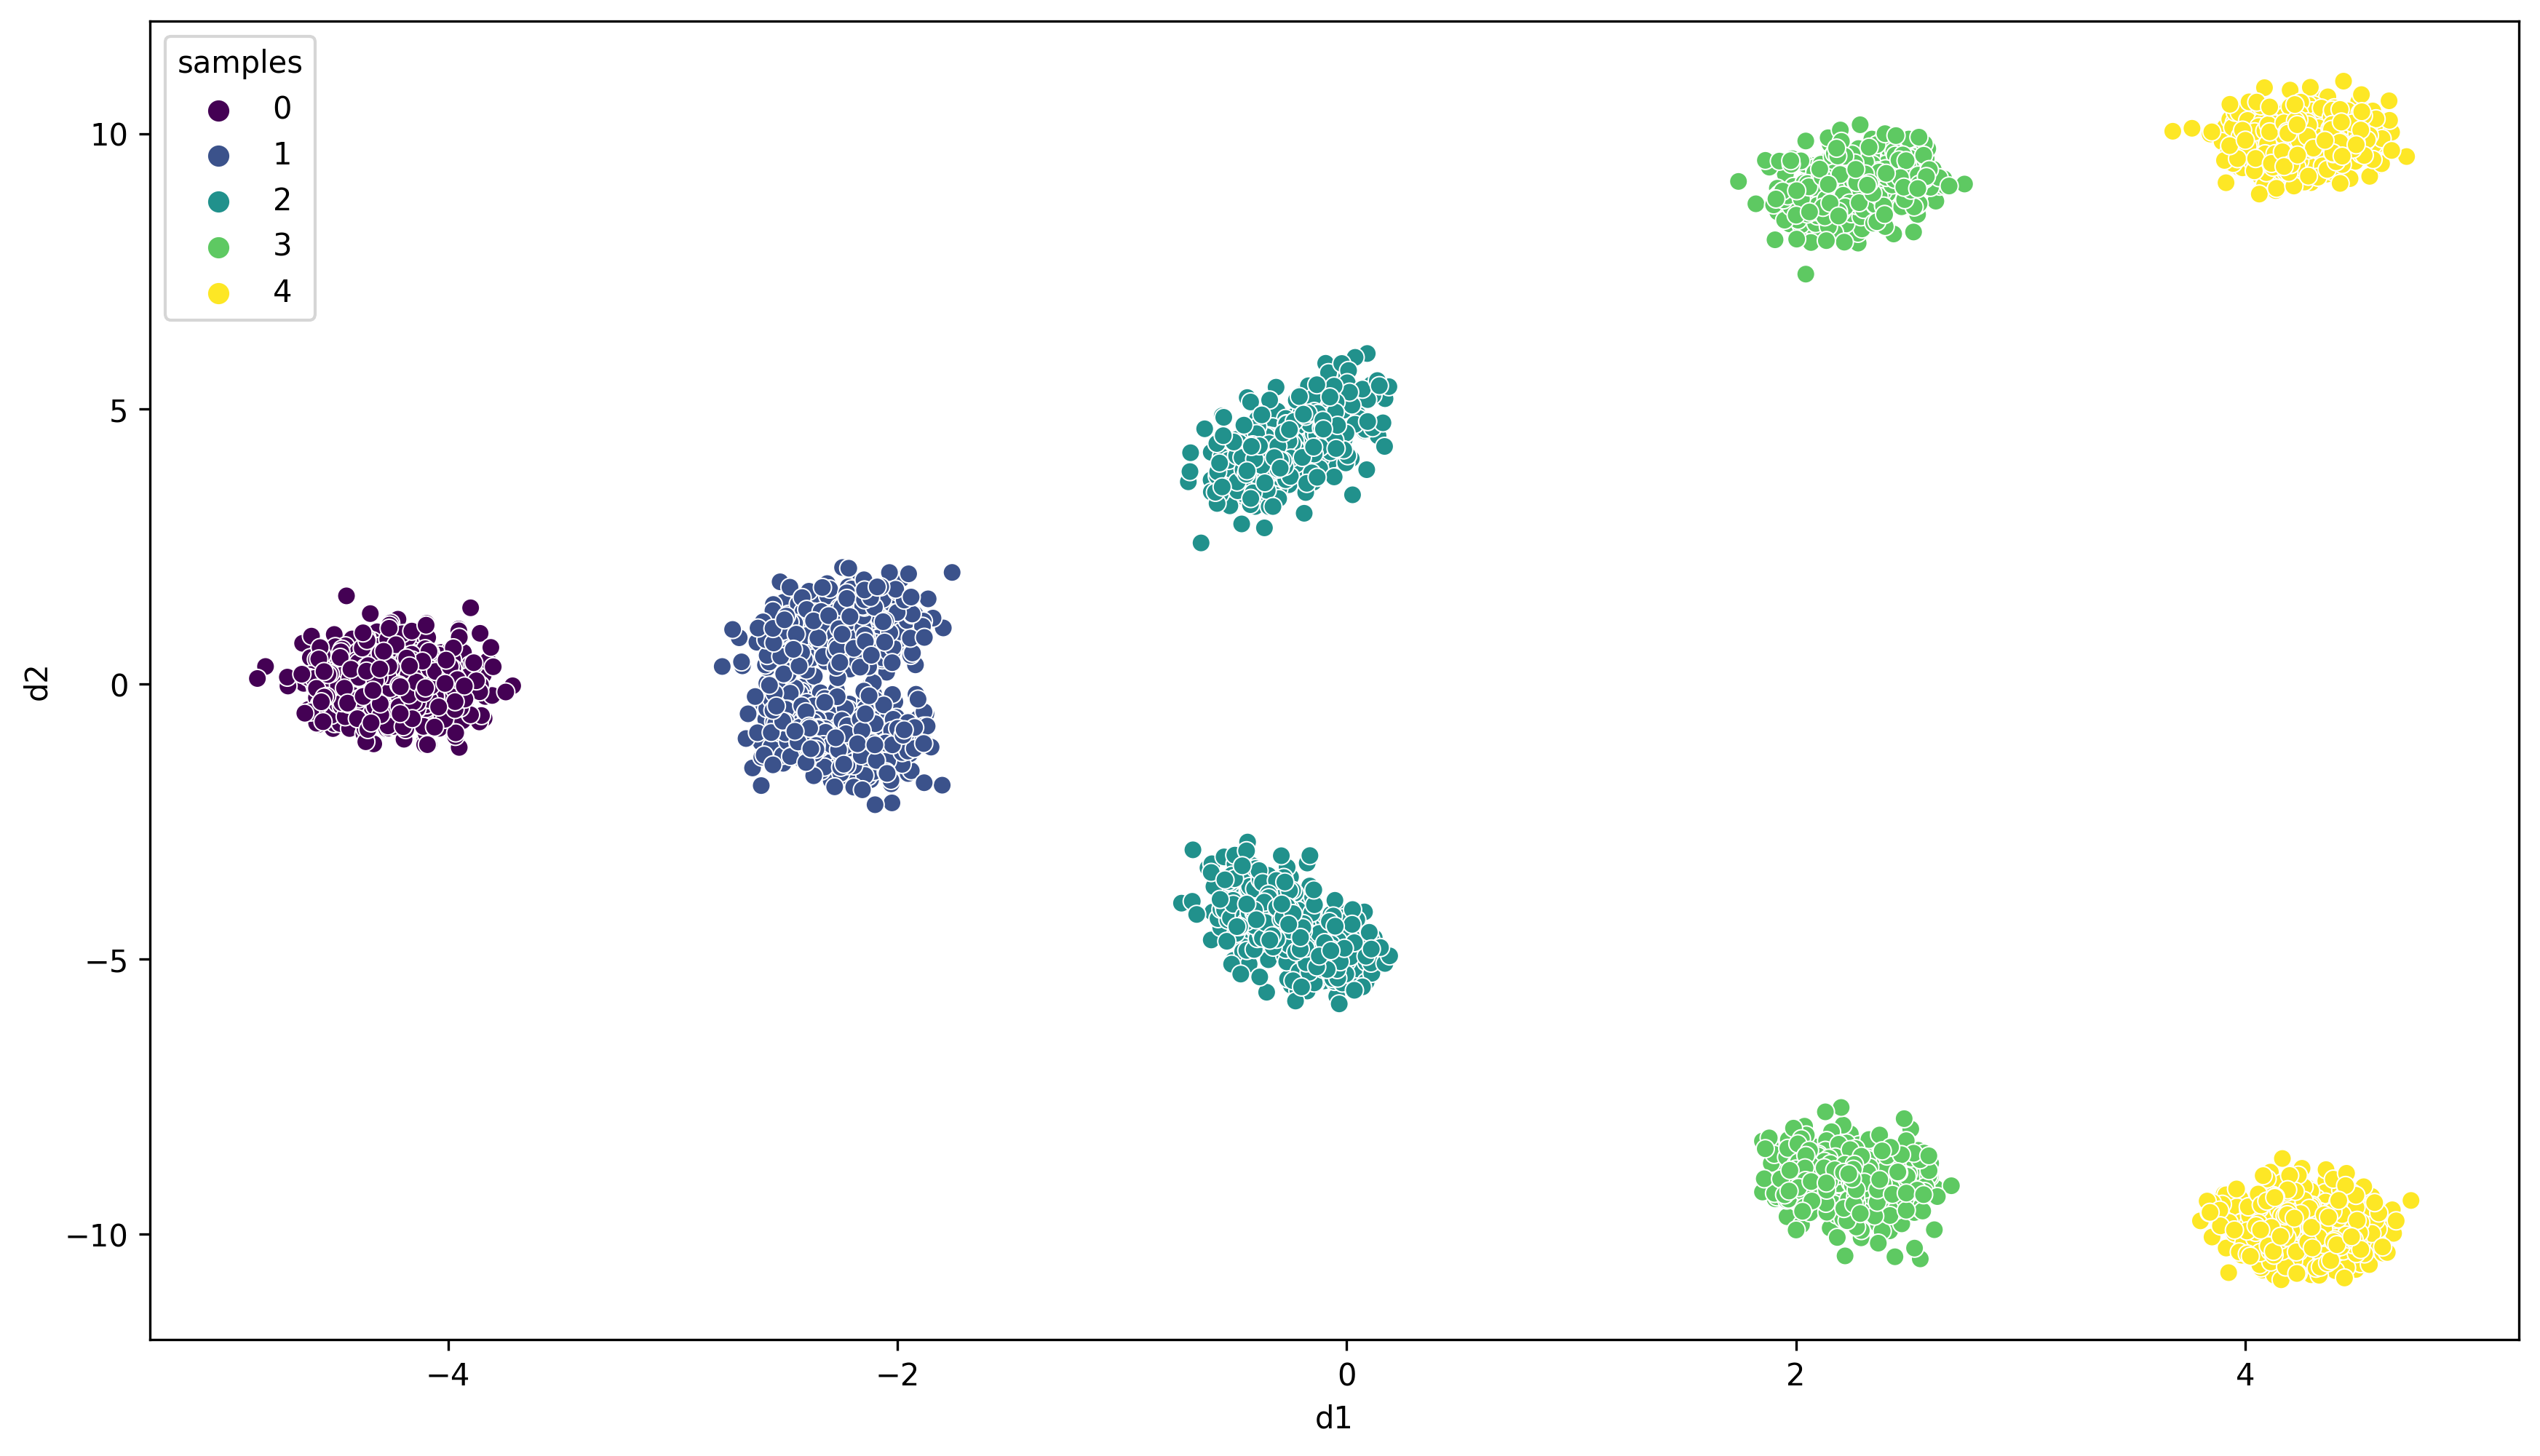

In [18]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

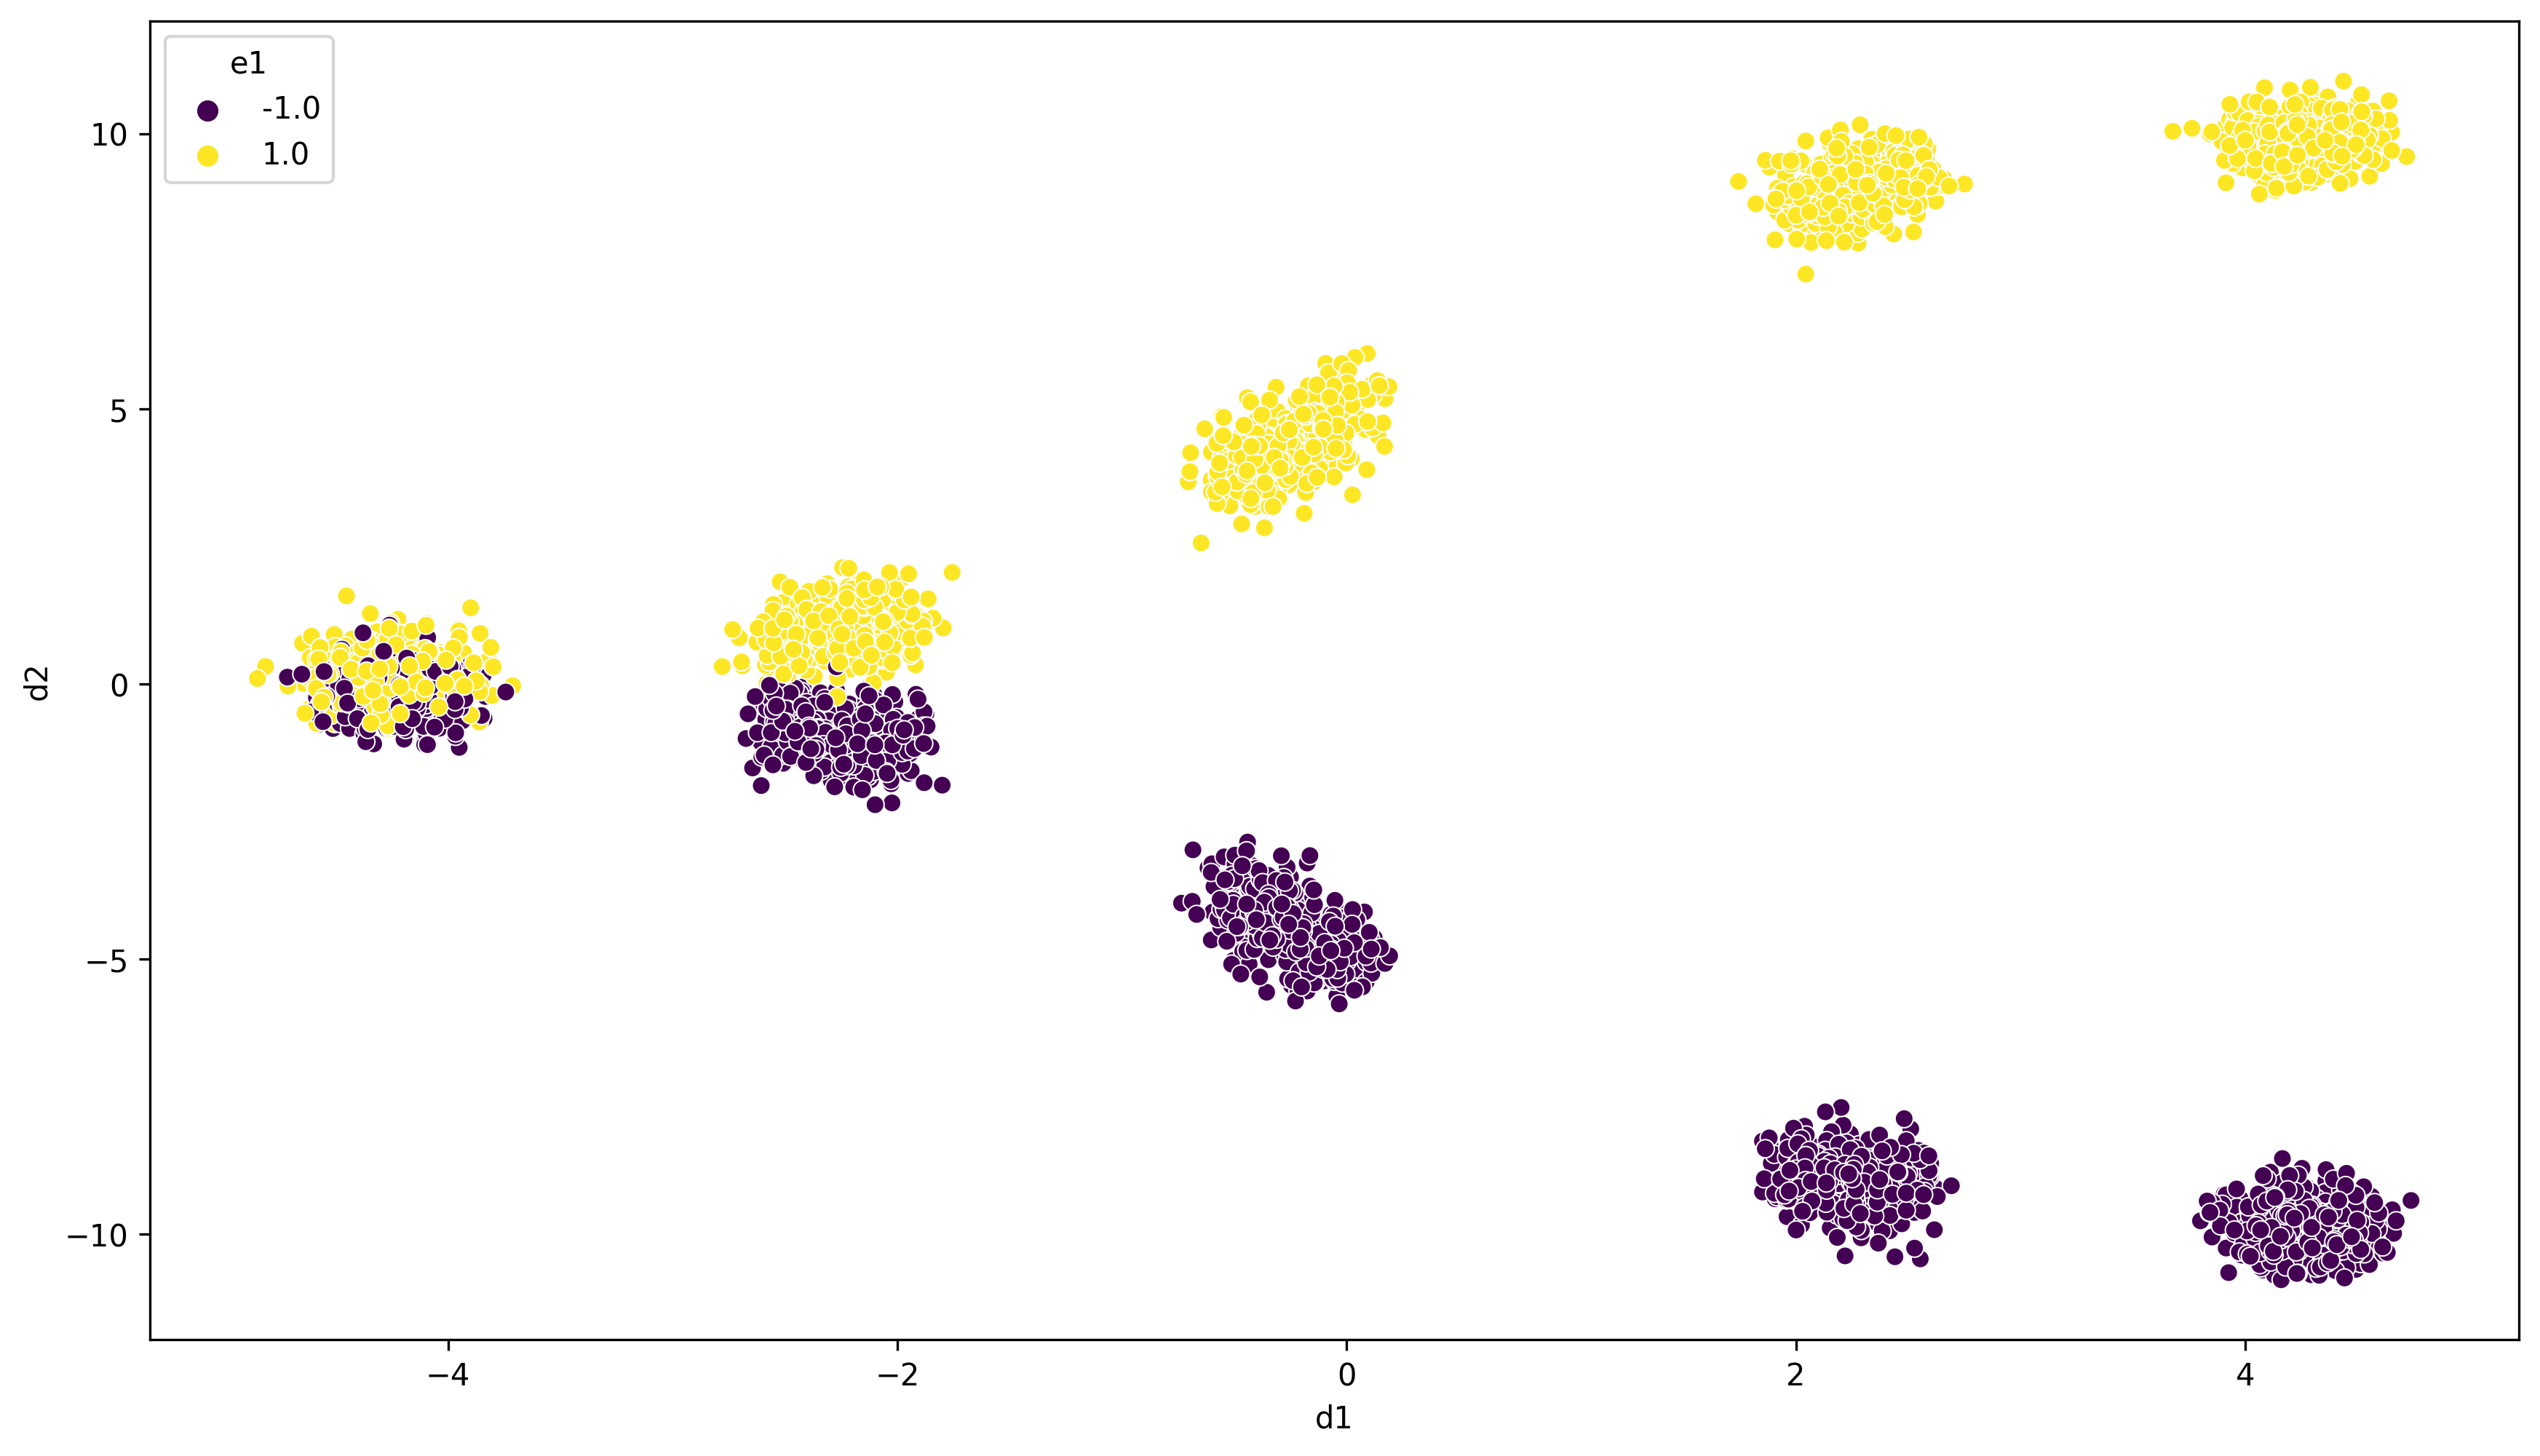

In [19]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [20]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [21]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1 - 1
groups = sorted(df.samples.unique())

In [22]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 3
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [23]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [385]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'
method = 'rk4'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 100

momentum_beta = 0.0

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [32,32,32]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim
n_conditions = 1
model = make_model(
    model_features, layers, 
    activation=activation, method = method, 
    scales=sde_scales, use_cuda=use_cuda, 
    n_conditions=n_conditions, momentum_beta = momentum_beta
)

In [386]:
# Basically "batch size"
sample_size=(40, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [387]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [388]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [389]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    use_penalty=True, lambda_energy=0.0,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    n_conditions=n_conditions,
    lambda_cond=1.,
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

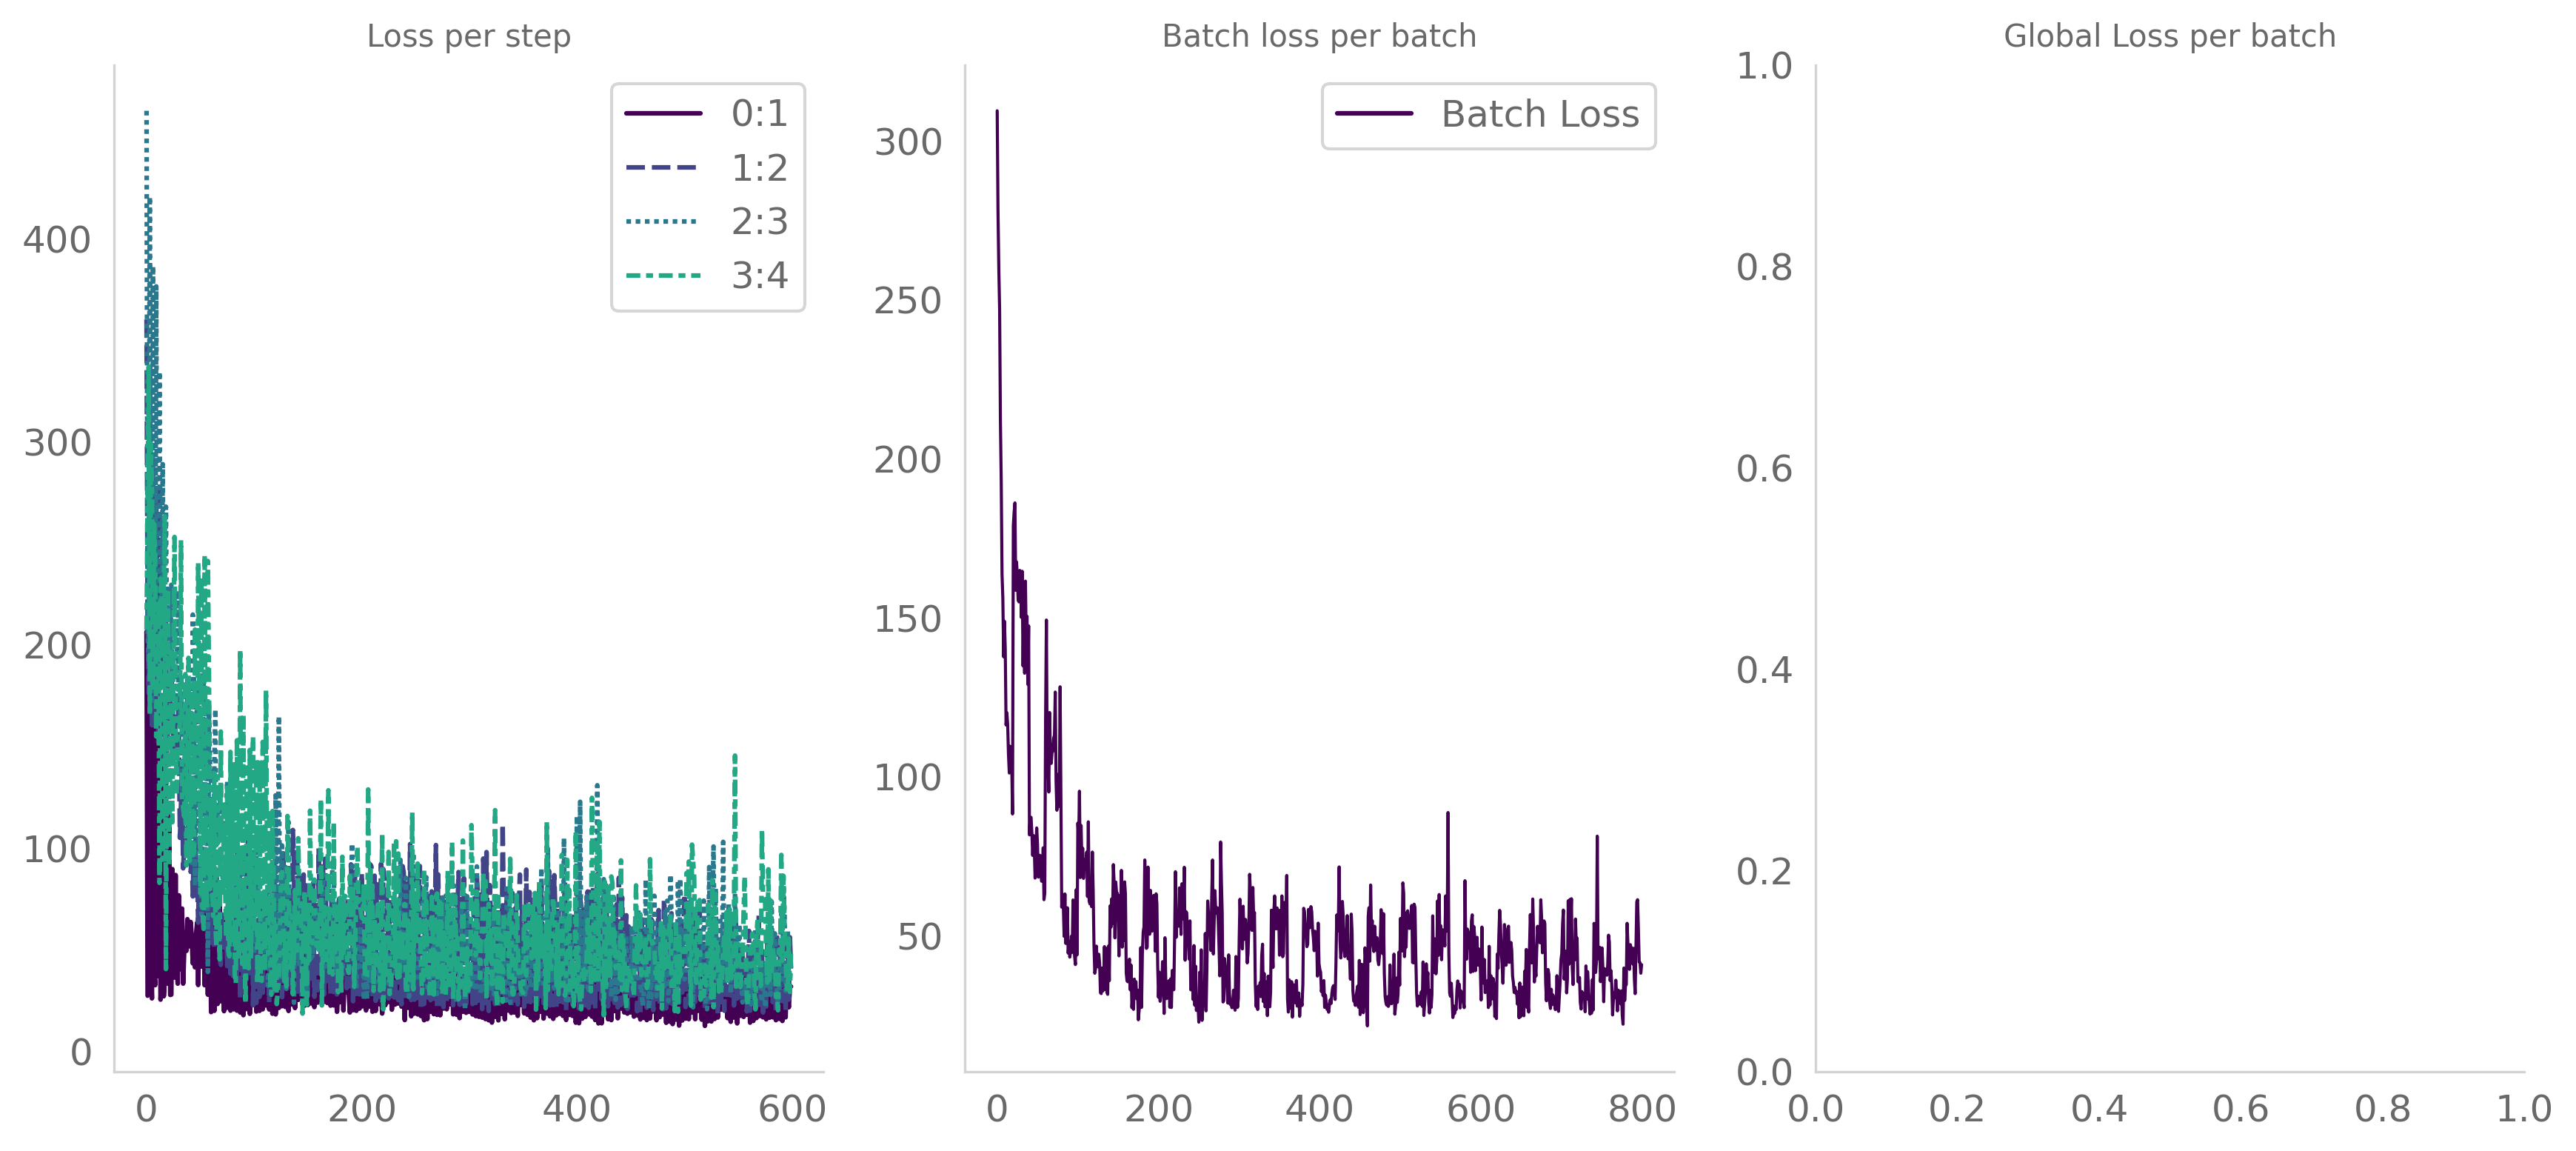

In [390]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=False, path=exp_dir, file='losses.png'
)

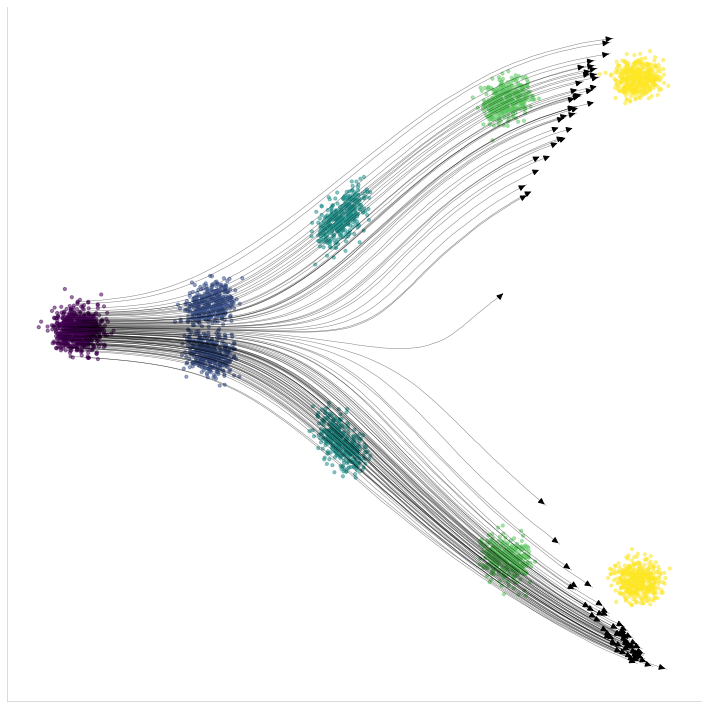

In [393]:
model.eval()
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
np.random.seed(32)
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
# data_t0 = torch.tensor([[-1., 0.]], dtype=torch.float32, device='cpu')
fig, ax = plt.subplots(figsize=(10, 10))

sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

scatter = ax.scatter(df['d1'], df['d2'],
                c=df['samples'], cmap='viridis', s=10, alpha=.5)

ax.set_xticks([])
ax.set_yticks([])

for i,traj in enumerate(np.transpose(x_traj.cpu(), axes=(1,0,2))):
    ax.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=1))

plt.tight_layout()

## momentum = 0.3

In [379]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'
method = 'rk4'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 100

momentum_beta = 0.3

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [32,32,32]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim
n_conditions = 1
model = make_model(
    model_features, layers, 
    activation=activation, method = method, 
    scales=sde_scales, use_cuda=use_cuda, 
    n_conditions=n_conditions, momentum_beta = momentum_beta
)

In [380]:
# Basically "batch size"
sample_size=(40, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [381]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [382]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    use_penalty=True, lambda_energy=0.0,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    n_conditions=n_conditions,
    lambda_cond=1.,
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

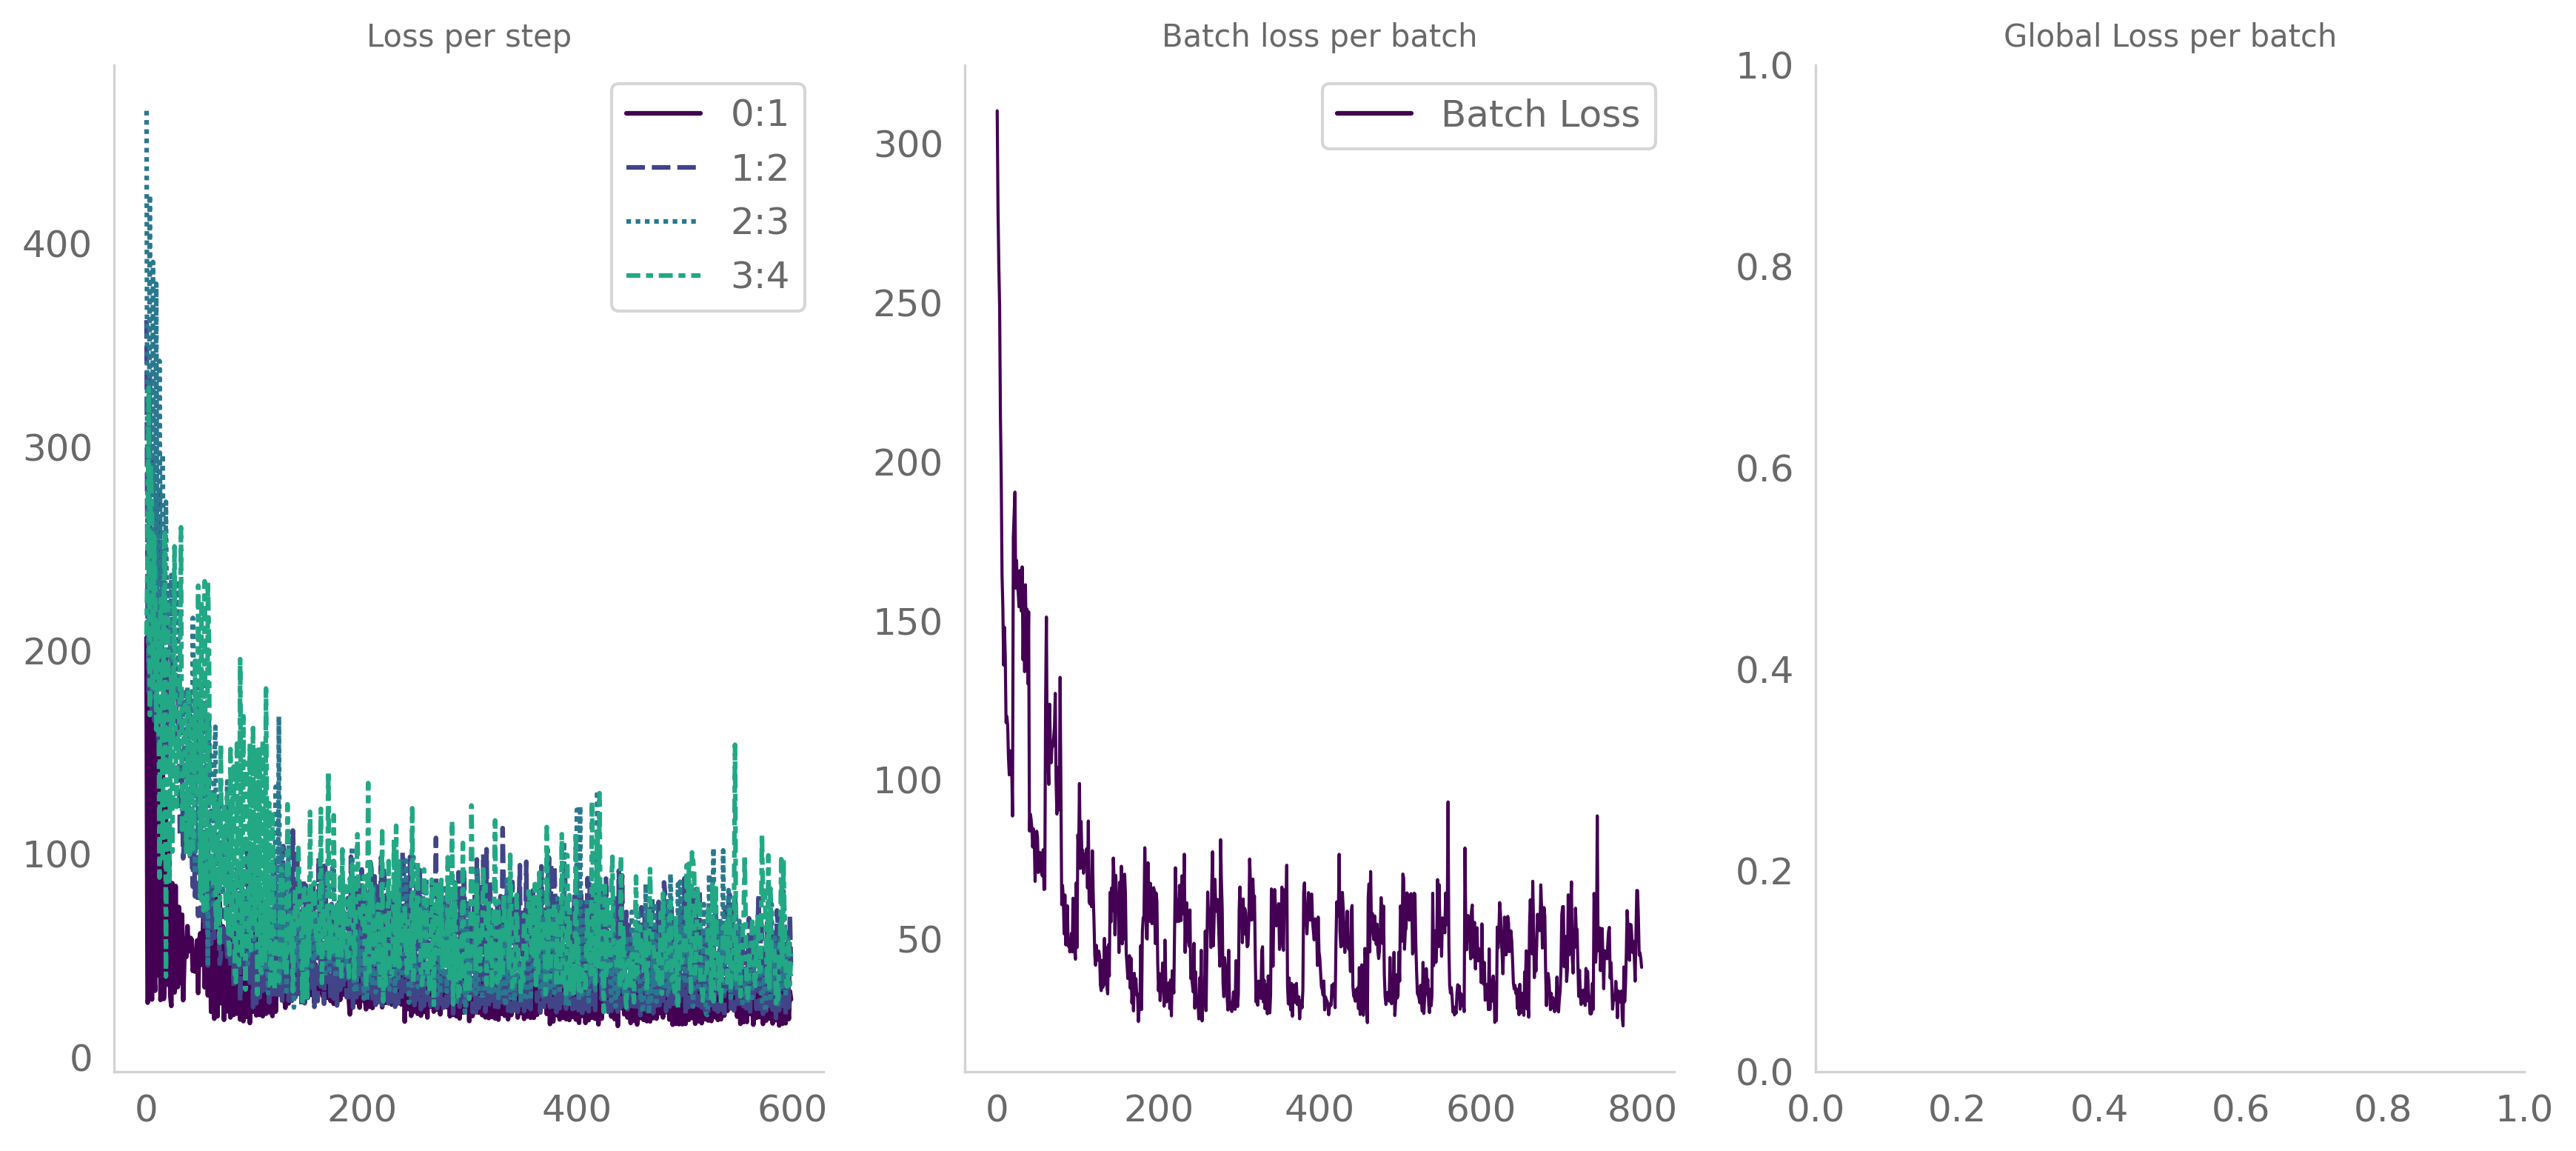

In [383]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=False, path=exp_dir, file='losses.png'
)

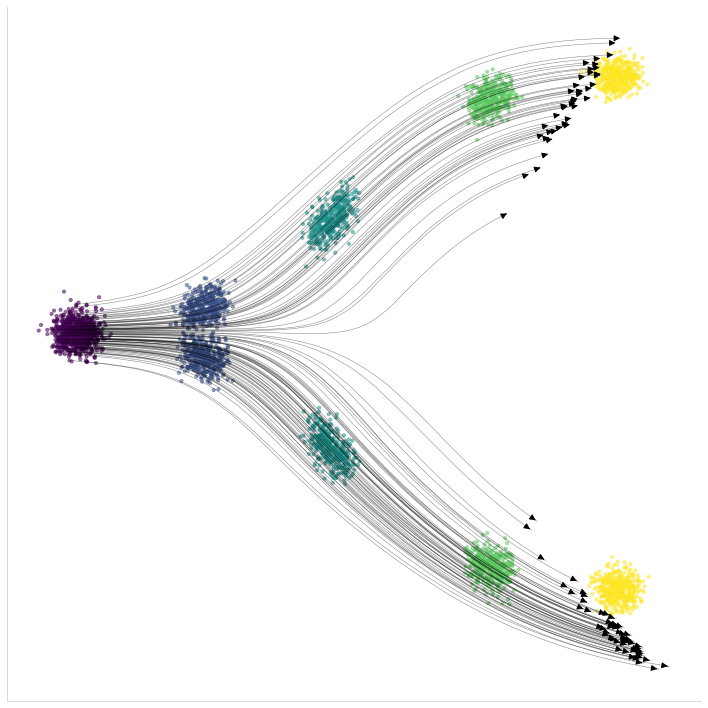

In [384]:
model.eval()
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
np.random.seed(32)
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
# data_t0 = torch.tensor([[-1., 0.]], dtype=torch.float32, device='cpu')
fig, ax = plt.subplots(figsize=(10, 10))

sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

scatter = ax.scatter(df['d1'], df['d2'],
                c=df['samples'], cmap='viridis', s=10, alpha=.5)

ax.set_xticks([])
ax.set_yticks([])

for i,traj in enumerate(np.transpose(x_traj.cpu(), axes=(1,0,2))):
    ax.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=1))

plt.tight_layout()

## Momentum = 0.5

In [372]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'
method = 'rk4'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 100

momentum_beta = 0.5

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [32,32,32]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim
n_conditions = 1
model = make_model(
    model_features, layers, 
    activation=activation, method = method, 
    scales=sde_scales, use_cuda=use_cuda, 
    n_conditions=n_conditions, momentum_beta = momentum_beta
)

In [373]:
# Basically "batch size"
sample_size=(40, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [374]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [375]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    use_penalty=True, lambda_energy=0.0,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    n_conditions=n_conditions,
    lambda_cond=1.,
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

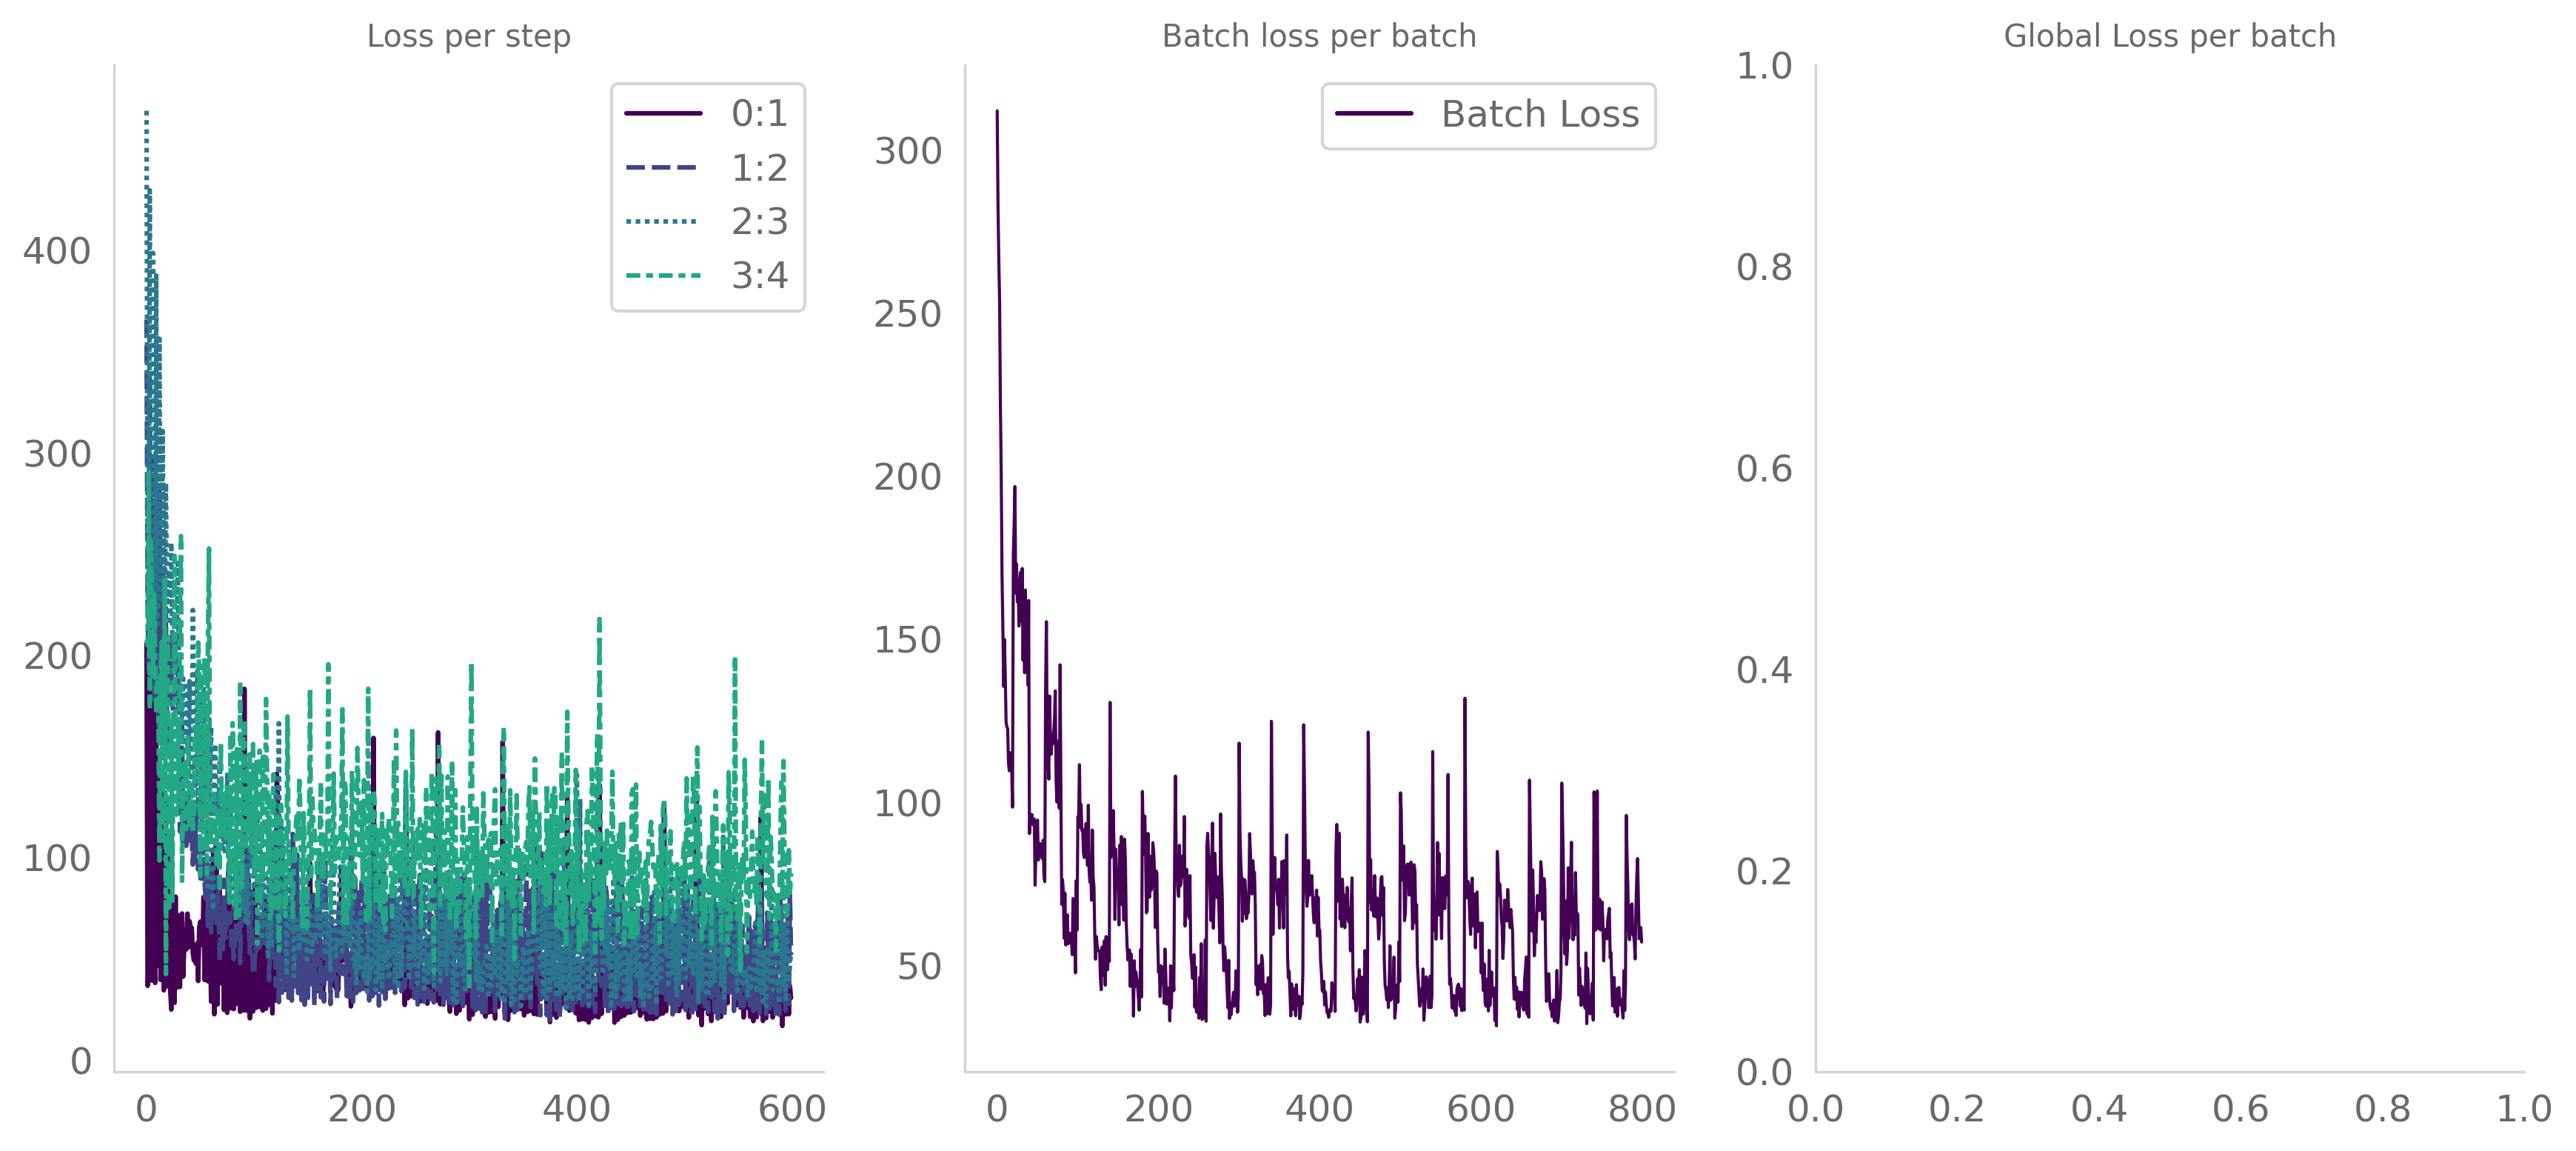

In [376]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=False, path=exp_dir, file='losses.png'
)

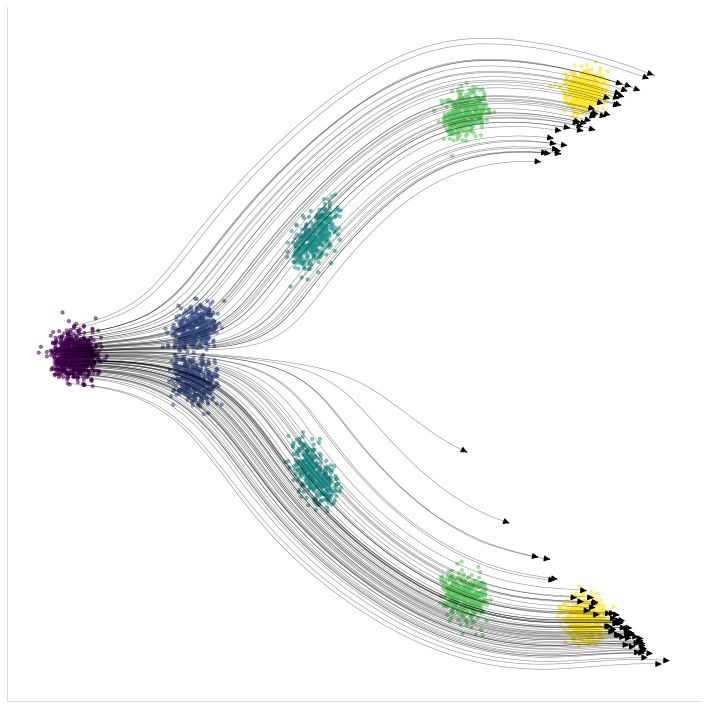

In [377]:
model.eval()
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
np.random.seed(32)
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
# data_t0 = torch.tensor([[-1., 0.]], dtype=torch.float32, device='cpu')
fig, ax = plt.subplots(figsize=(10, 10))

sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

scatter = ax.scatter(df['d1'], df['d2'],
                c=df['samples'], cmap='viridis', s=10, alpha=.5)

ax.set_xticks([])
ax.set_yticks([])

for i,traj in enumerate(np.transpose(x_traj.cpu(), axes=(1,0,2))):
    ax.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=1))

plt.tight_layout()